In [68]:
%load_ext google.colab.data_table

#Packages
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%tensorflow_version 2.x

#Tools
from tensorflow import keras
from statistics import mean
from google.colab import drive
from google.colab import data_table
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [69]:
from tensorflow.python.client import device_lib
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14779359288944297230]

In [70]:
#Avoid warnings
import warnings
warnings.filterwarnings('ignore')

#mount Drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"

#Configuration
pd.set_option('display.max_columns', None)
sns.set_palette("husl", 9)
class_names_complete = ['Sanos', 'Talasemias', 'Hemoglobinopatías', 'A.Ferropénicas', 'A.Crónico']
class_names_reduced = ['Sanos', 'Congénitas', 'Adquiridas']

Mounted at /content/drive


# Data loading

##Train-Samples

In [71]:
#Load CSV fie
CBC_file_dir = root_dir + "Data/ProcessedData-2021-Filtrados.csv"
CBC = pd.read_csv(CBC_file_dir, error_bad_lines=True)
CBC["Clase"] = CBC["Clase"].astype(int)
print('File loaded, shape:(%s, %s)' %((len(CBC), len(CBC.iloc[0]))))

File loaded, shape:(3295, 18)


In [72]:
#Check random sample
data_table.DataTable(CBC.head(100), include_index=False, num_rows_per_page=10)

,Edad,WBC,LYAB,MOAB,NEAB,EO,BA,HEMA,HGB,HTO,VCM,MCH,CHCM,RDW,PLT,VPM,Clase,TipoClase
0,0.117647,0.145740,0.075908,0.250000,0.118182,0.351429,0.122807,0.376455,0.605882,0.530957,0.451574,0.455738,0.715385,0.068493,0.089410,0.557692,0,-1.0
1,0.519608,0.087444,0.049505,0.107143,0.090909,0.034286,0.087719,0.331177,0.582353,0.491557,0.483051,0.504918,0.769231,0.037671,0.099826,0.259615,0,-1.0
2,0.441176,0.132287,0.029703,0.214286,0.186364,0.065714,0.245614,0.469599,0.647059,0.579737,0.366828,0.367213,0.676923,0.157534,0.231771,0.250000,0,-1.0
3,0.754902,0.177130,0.016502,0.142857,0.318182,0.005714,0.000000,0.291074,0.458824,0.382739,0.395884,0.413115,0.723077,0.157534,0.211806,0.307692,0,-1.0
4,0.666667,0.161435,0.066007,0.214286,0.195455,0.108571,0.122807,0.397154,0.694118,0.604128,0.515738,0.527869,0.746154,0.130137,0.150174,0.346154,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.784314,0.304933,0.110398,0.217705,0.184689,0.028571,0.350877,0.278137,0.629412,0.568480,0.727603,0.681967,0.661538,0.335616,0.163194,0.365385,0,-1.0
96,0.480392,0.109865,0.033003,0.285714,0.118182,0.174286,0.403509,0.363519,0.652941,0.527205,0.470944,0.537705,0.869231,0.109589,0.198785,0.413462,0,-1.0
97,0.833333,0.426009,0.264026,0.285714,0.459091,0.008571,0.035088,0.510996,0.682353,0.632270,0.369249,0.350820,0.623077,0.106164,0.196181,0.365385,0,-1.0
98,0.656863,0.154709,0.056106,0.178571,0.204545,0.082857,0.087719,0.454075,0.741176,0.643527,0.467312,0.488525,0.761538,0.089041,0.179688,0.461538,0,-1.0


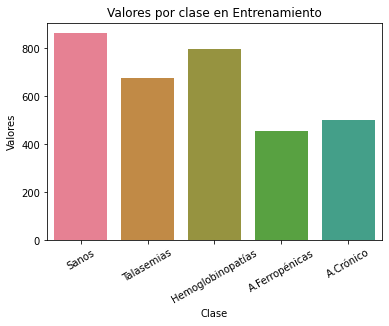

In [73]:
chart = sns.countplot(x='Clase', data=CBC)
plt.ylabel("Valores")
plt.title('Valores por clase en Entrenamiento')
chart.set_xticklabels(class_names_complete, rotation=30, fontsize=10);

## Validation-Samples

In [74]:
#Load CSV fie
CBCVal21_file_dir = root_dir + "Data/POST-ProcessedData-2021-Filtrados.csv"
CBCVal21 = pd.read_csv(CBCVal21_file_dir, error_bad_lines=True)
CBCVal21["Clase"] = CBCVal21["Clase"].astype(int)
print('File loaded, TEST, shape:(%s, %s)' %((len(CBCVal21), len(CBCVal21.iloc[0]))))

File loaded, TEST, shape:(221, 18)


In [75]:
#Check random sample
data_table.DataTable(CBCVal21.head(100), include_index=False, num_rows_per_page=10)

,Edad,WBC,LYAB,MOAB,NEAB,EO,BA,HEMA,HGB,HTO,VCM,MCH,CHCM,RDW,PLT,VPM,Clase,TipoClase
0,0.504132,0.190909,0.324324,0.260870,0.137195,0.276471,0.081967,0.567568,0.828571,0.748503,0.861171,0.909574,0.909910,0.036036,0.192825,0.400000,0,-1.0
1,0.636364,0.206061,0.108108,0.347826,0.201220,0.088235,0.131148,0.585586,0.780952,0.715569,0.778742,0.824468,0.882883,0.049550,0.203288,0.542857,0,-1.0
2,0.677686,0.145455,0.067568,0.217391,0.158537,0.135294,0.147541,0.387387,0.523810,0.502994,0.828633,0.840426,0.837838,0.076577,0.303438,0.385714,0,-1.0
3,0.305785,0.366667,0.189189,0.304348,0.347561,0.035294,0.065574,0.635135,0.809524,0.769461,0.767896,0.787234,0.828829,0.031532,0.124066,0.514286,0,-1.0
4,0.239669,0.109091,0.094595,0.173913,0.121951,0.117647,0.114754,0.484234,0.666667,0.628743,0.837310,0.851064,0.846847,0.022523,0.101644,0.828571,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.081818,0.121622,0.173913,0.085366,0.247059,0.065574,0.123874,0.228571,0.200599,0.893709,0.946809,0.918919,0.000000,0.092676,0.871429,4,2.0
96,0.743802,0.157576,0.189189,0.260870,0.143293,0.047059,0.081967,0.236486,0.257143,0.287425,0.765727,0.734043,0.729730,0.081081,0.153961,0.428571,4,2.0
97,0.752066,0.000000,0.027027,0.130435,0.030488,0.147059,0.360656,0.182432,0.247619,0.269461,0.882863,0.845745,0.756757,0.022523,0.182362,0.414286,4,2.0
98,0.801653,0.066667,0.189189,0.173913,0.057927,0.111765,0.049180,0.189189,0.314286,0.317365,0.969631,0.930851,0.783784,0.009009,0.234679,0.314286,4,2.0


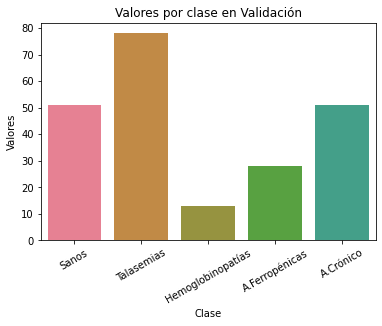

In [76]:
chart = sns.countplot(x='Clase', data=CBCVal21)
plt.ylabel("Valores")
plt.title('Valores por clase en Validación')
chart.set_xticklabels(class_names_complete, rotation=30, fontsize=10);

# Data Selection

In [77]:
#Train
CBC = CBC[CBC['Clase'] != 2]
#CBC['Clase'] = CBC['Clase'].replace(to_replace = 2, value = 1)
CBC['Clase'] = CBC['Clase'].replace(to_replace = 3, value = 2) 
CBC['Clase'] = CBC['Clase'].replace(to_replace = 4, value = 2) 

In [78]:
healthy = CBC.loc[CBC['Clase'] == 0]
thalassemias = CBC.loc[CBC['Clase'] == 1]
anemias = CBC.loc[CBC['Clase'] == 2]

#Pick only specific thalassemias
#thalassemias = thalassemias.loc[(thalassemias['TipoClase'] == 7) | (thalassemias['TipoClase'] == 4) | (thalassemias['TipoClase'] == 3)]

CBC = pd.concat([healthy,thalassemias, anemias])
print(CBC['Clase'].value_counts(sort=False))

0    863
2    959
1    675
Name: Clase, dtype: int64


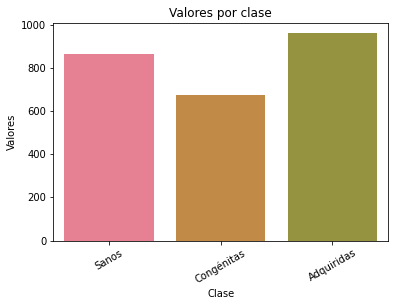

In [79]:
chart = sns.countplot(x='Clase', data=CBC)
plt.ylabel("Valores")
plt.title('Valores por clase')
chart.set_xticklabels(class_names_reduced, rotation=30, fontsize=10);

In [80]:
#Test
CBCVal21 = CBCVal21[CBCVal21['Clase'] != 2]
#CBCVal21['Clase'] = CBCVal21['Clase'].replace(to_replace = 2, value = 1)
CBCVal21['Clase'] = CBCVal21['Clase'].replace(to_replace = 3, value = 2) 
CBCVal21['Clase'] = CBCVal21['Clase'].replace(to_replace = 4, value = 2) 

In [81]:
healthyVal = CBCVal21.loc[CBCVal21['Clase'] == 0]
thalassemiasVal = CBCVal21.loc[CBCVal21['Clase'] == 1]
anemiasVal = CBCVal21.loc[CBCVal21['Clase'] == 2]

#Pick only specific thalassemias
#thalassemiasVal = thalassemias.loc[(thalassemias['TipoClase'] == 7) | (thalassemias['TipoClase'] == 4) | (thalassemias['TipoClase'] == 3)]

CBCVal21 = pd.concat([healthyVal,thalassemiasVal, anemiasVal])
print(CBCVal21['Clase'].value_counts())

2    79
1    78
0    51
Name: Clase, dtype: int64


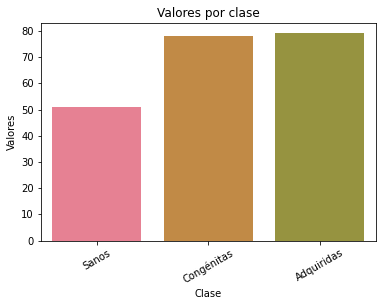

In [82]:
chart = sns.countplot(x='Clase', data=CBCVal21)
plt.ylabel("Valores")
plt.title('Valores por clase')
chart.set_xticklabels(class_names_reduced, rotation=30, fontsize=10);

## Separating labels


In [83]:
#Train
CBC = CBC.sample(frac = 1)

labels = CBC['Clase']
CBC = CBC.drop('Clase', axis=1)
CBC = CBC.drop('TipoClase', axis=1)
CBC.replace(0,CBC.mean(axis=0),inplace=True)

In [84]:
#Test
CBCVal21 = CBCVal21.sample(frac = 1)

labelsVal = CBCVal21['Clase']
CBCVal21 = CBCVal21.drop('Clase', axis=1)
CBCVal21 = CBCVal21.drop('TipoClase', axis=1)
CBCVal21.replace(0,CBCVal21.mean(axis=0),inplace=True)

In [85]:
print(CBC.columns)

Index(['Edad', 'WBC', 'LYAB', 'MOAB', 'NEAB', 'EO', 'BA', 'HEMA', 'HGB', 'HTO',
       'VCM', 'MCH', 'CHCM', 'RDW', 'PLT', 'VPM'],
      dtype='object')


In [86]:
CBC = CBC.to_numpy()
CBCVal21 = CBCVal21.to_numpy()

# Neural Network

## Hyperparameters


In [87]:
regularization_l2_rate = 1e-06
learning_rate = 1e-05
hidden_units = 64
batch_size = 64
epochs = 2500
activation = 'selu'

def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 500
    if epoch % decay_step == 0 and epoch:
        return lr*decay_rate
    return lr

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)

classes=['Sanos','Congenitas','Adquiridas']

## Model definition

In [88]:
def createModel(activation='relu',learning_rate=0.0001, regularization_l2_rate=0.00001, hidden_units = 32):
  from tensorflow.keras.models import Model
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Dense, Input, Lambda
  from tensorflow.keras.layers import Dropout, BatchNormalization, concatenate
  from keras import regularizers

  initializer = keras.initializers.GlorotNormal(seed=None)

  combi_input = Input(shape=(31, )) # (None, 3)

  whitecells_input = Lambda(lambda x: x[:, 1:7], name = 'WhiteCells_Input')(combi_input) # (None, 1)
  redcells_input = Lambda(lambda x: x[:, 7:14], name = 'RedCells_Input')(combi_input) # (None, 1) 
  pltcells_input = Lambda(lambda x: x[:, 14:16], name = 'PltCells_Input')(combi_input) # (None, 1)
  full_input = Lambda(lambda x: x[:, 0:16])(combi_input) # (None, 1)


  #redcells_input = Input(shape=(7, ), name = 'RedCells_Input')
  redcells_dense = Dense(16, activation=activation, kernel_initializer=initializer, use_bias=True, bias_initializer='zeros', 
                  kernel_regularizer=regularizers.l2(regularization_l2_rate), name = 'RedCells_Dense')(redcells_input)

  #pltcells_input = Input(shape=(2, ), name = 'PltCells_Input')
  pltcells_dense = Dense(8, activation=activation, kernel_initializer=initializer, use_bias=True, bias_initializer='zeros', 
                         kernel_regularizer=regularizers.l2(regularization_l2_rate), name = 'PltCells_Dense')(pltcells_input)

  merge_pltred = concatenate([redcells_dense, pltcells_dense], name = 'PLT-Red_Concatenate')

  dense1 = Dense(units=hidden_units, activation=activation, kernel_initializer=initializer, use_bias=True, bias_initializer='zeros', 
                  kernel_regularizer=regularizers.l2(regularization_l2_rate),  name = 'Dense1')(merge_pltred)

  #whitecells_input = Input(shape=(6, ), name = 'WhiteCells_Input')
  whitecells_dense = Dense(16, activation=activation,  kernel_initializer=initializer, use_bias=True, bias_initializer='zeros', 
                  kernel_regularizer=regularizers.l2(regularization_l2_rate), name = 'WhiteCells_Dense' )(whitecells_input)
  
  merge_whitetredplt = concatenate([dense1, whitecells_dense], name = 'White-PLT-Red_Concatenate')

  dense2 = Dense(units=hidden_units*2, activation=activation, kernel_initializer=initializer, use_bias=True, bias_initializer='zeros', 
                  kernel_regularizer=regularizers.l2(regularization_l2_rate),  name = 'Dense2')(merge_whitetredplt)

  #full_input = Input(shape=(16, ))
  full_dense = Dense(32, activation=activation, kernel_initializer=initializer, use_bias=True, bias_initializer='zeros', 
                  kernel_regularizer=regularizers.l2(regularization_l2_rate), name = 'Full_Inputs' )(full_input)

  merge_all = concatenate([dense2, full_dense], name = 'Full_Concatenate')

  dense3 = Dense(units=hidden_units*4, activation=activation, kernel_initializer=initializer, use_bias=True, bias_initializer='zeros', 
                  kernel_regularizer=regularizers.l2(regularization_l2_rate),  name = 'Dense3')(merge_all)

  dense4 = Dense(units=hidden_units*2, activation=activation, kernel_initializer=initializer, use_bias=True, bias_initializer='zeros', 
                  kernel_regularizer=regularizers.l2(regularization_l2_rate),  name = 'Dense4')(dense3)

  output_layer = Dense(3, activation='softmax', name = 'output_layer')(dense4)

  model = Model(inputs=combi_input, outputs=output_layer)

  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics = ['accuracy'])
                
  return model

# Training

## Run

In [89]:
from sklearn.utils import shuffle

test_acc_max = 0
best_model = ""
combi_input_max = ""
y_true_max = ""
best_history = ""
scores = []

for i in range(0,2):

  x_train, x_test, y_train, y_test = train_test_split(CBC, labels, test_size=0.10, shuffle=True)

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')


  class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)))
  
  y_true = y_test

  y_train = to_categorical(y_train, num_classes=3)
  y_test = to_categorical(y_test, num_classes=3)

  model = createModel(activation=activation,learning_rate=learning_rate, regularization_l2_rate=regularization_l2_rate)

  combi_input = np.concatenate([x_train[:,1:7], x_train[:,7:14],x_train[:,14:16], x_train], axis=1)

  combi_input_test = np.concatenate([x_test[:,1:7], x_test[:,7:14],x_test[:,14:16],x_test], axis=1)

  history = model.fit(combi_input, y_train, validation_data=(combi_input_test,y_test), epochs=epochs, batch_size=batch_size, class_weight=class_weights, verbose=0, callbacks=[reduce_lr, callback_es])
  test_loss, test_acc = model.evaluate(combi_input_test, y_test)
  scores.append(test_acc)
  if(test_acc > test_acc_max):
    test_acc_max = test_acc
    best_model = model
    combi_input_max = combi_input_test
    y_true_max = y_true
    best_history = history

print('Max accuracy:', test_acc_max)
print('Mean accuracy:', mean(scores))

8/8 [==============================] - 0s 3ms/step - loss: 0.3813 - accuracy: 0.8600
Max accuracy: 0.8920000195503235
Mean accuracy: 0.8760000169277191


# Results

## Architecture

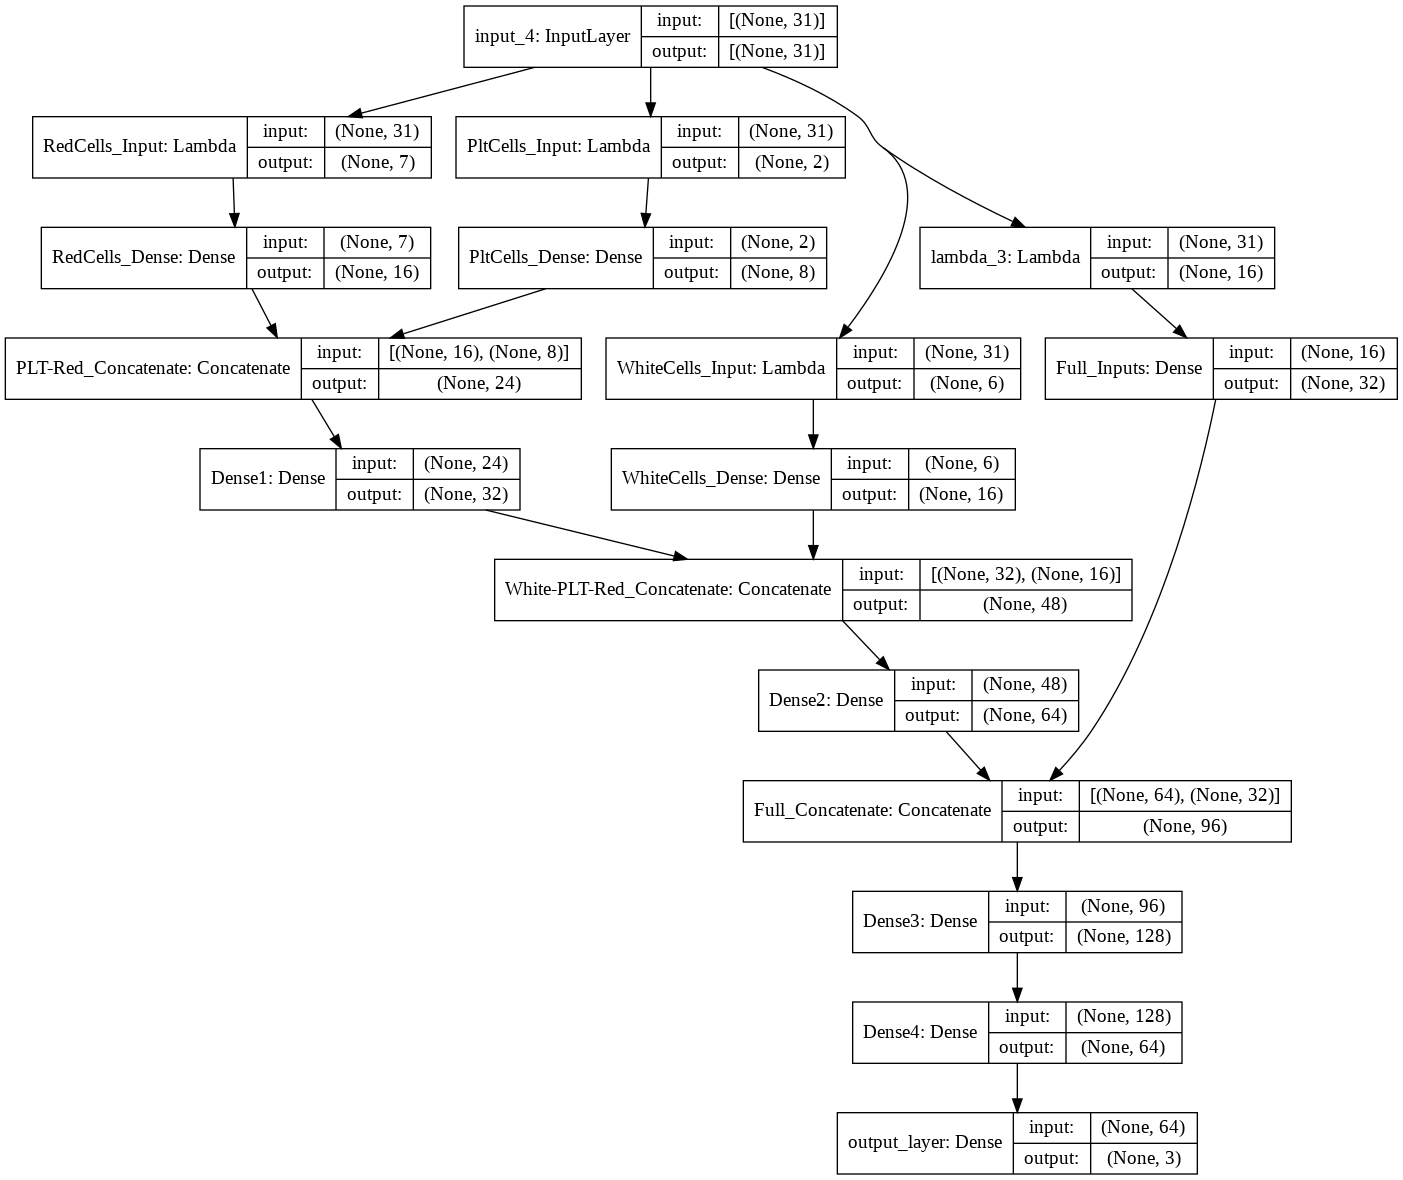

In [90]:
keras.utils.plot_model(model, root_dir +'multi_input_and_output_model.png', show_shapes=True)

## Report

In [91]:
y_pred=np.argmax(best_model.predict(combi_input_max), axis=-1)
report = classification_report(y_true_max, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        94
           1       0.81      0.91      0.86        65
           2       0.88      0.82      0.85        91

    accuracy                           0.89       250
   macro avg       0.89      0.89      0.89       250
weighted avg       0.90      0.89      0.89       250



## Confussion Matrix

Accuracy Y_test:  0.892


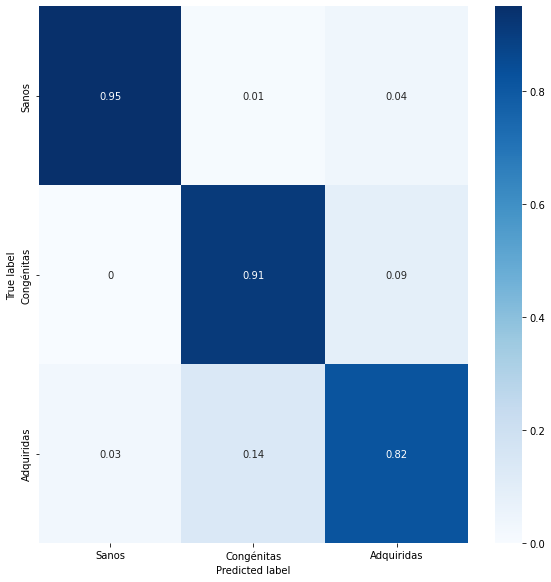

In [94]:
con_mat = tf.math.confusion_matrix(labels=y_true_max, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = class_names_reduced, columns = class_names_reduced)

print('Accuracy Y_test: ', accuracy_score(y_true_max, y_pred))
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Accuracy

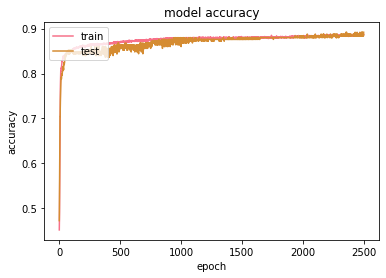

In [95]:
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loss

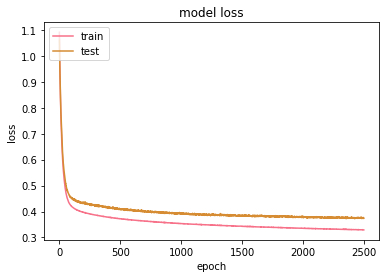

In [96]:
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Validation 2021


In [97]:
x_val, y_val = shuffle(CBCVal21, labelsVal)
combi_input_val = np.concatenate([x_val[:,1:7], x_val[:,7:14],x_val[:,14:16],x_val], axis=1)

Accuracy Y_Val:  0.8990384615384616


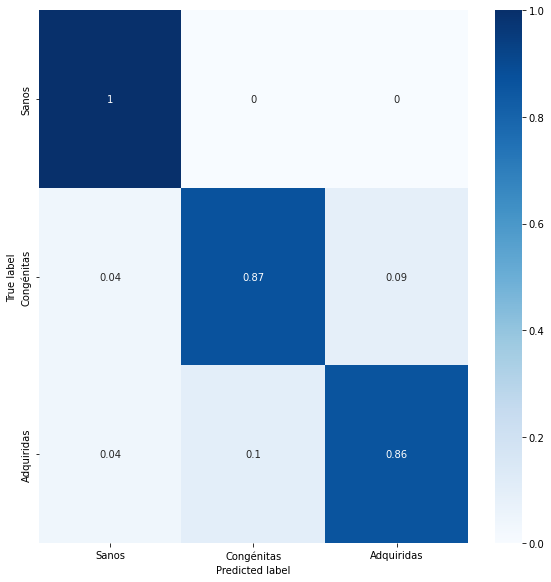

In [98]:
y_pred=np.argmax(best_model.predict(combi_input_val), axis=-1)

con_mat = tf.math.confusion_matrix(labels=y_val, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = class_names_reduced, columns = class_names_reduced)

print('Accuracy Y_Val: ', accuracy_score(y_val, y_pred))
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()